###### Imports

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

import re, string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import pickle


from wordcloud import WordCloud

###### Importing dataset

In [13]:
train = pd.read_csv("TextClassificationData/train.csv")
test = pd.read_csv("TextClassificationData/test.csv")

##### Looking into the data

In [14]:
display(train.head())

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [16]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [17]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

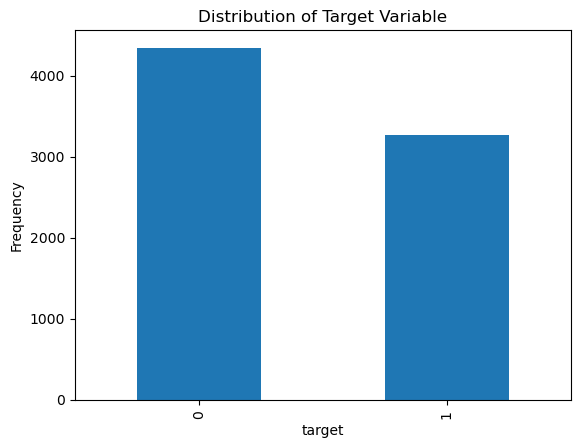

In [18]:
# Distribution of target variable

train.groupby('target').target.count().plot.bar()
plt.title("Distribution of Target Variable")
plt.ylabel("Frequency")
plt.show()

###### ***The bar plot shows that the dataset is nearly balanced***

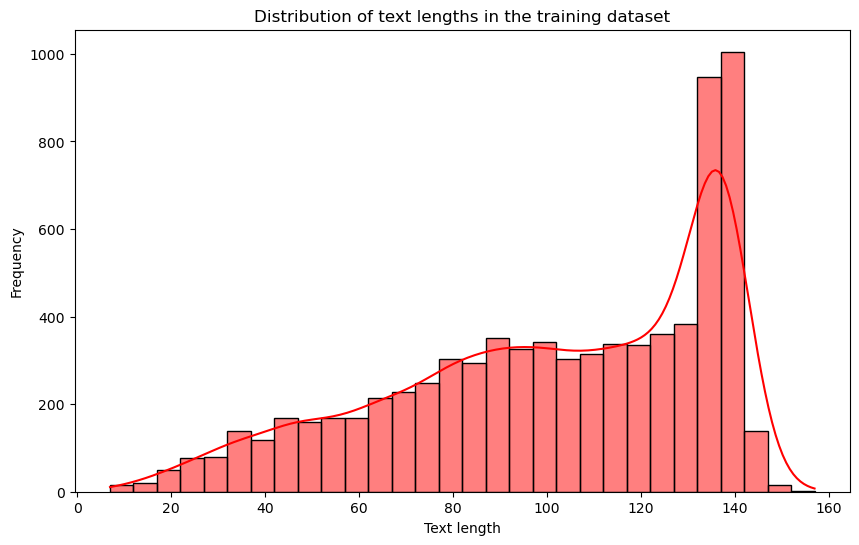

In [19]:
# Distribution of text lengths in the training dataset

train['text_length'] = train['text'].apply(len)

plt.figure(figsize = (10, 6))
sns.histplot(train['text_length'], bins = 30, kde = True, color = 'red')
plt.title("Distribution of text lengths in the training dataset")
plt.xlabel("Text length")
plt.ylabel('Frequency')
plt.show()

In [20]:
# Transforming text data into numerical features

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(train['text'])

train_text_features = tfidf_vectorizer.transform(train['text'])
test_text_features = tfidf_vectorizer.transform(test['text'])

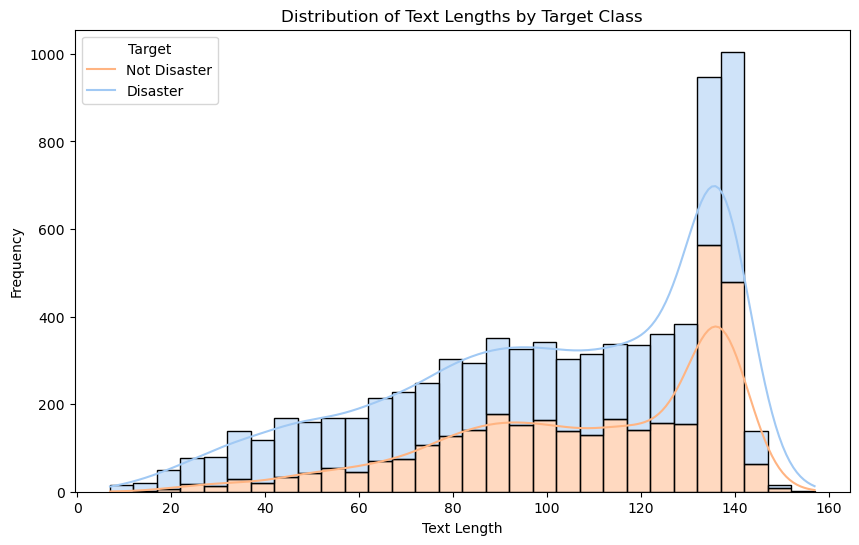

In [21]:
# Distribution of Text Lengths by Target Class

plt.figure(figsize = (10, 6))
sns.histplot(x = 'text_length', hue = 'target', data = train, bins = 30, kde = True, multiple = 'stack', palette = 'pastel')
plt.title('Distribution of Text Lengths by Target Class')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend(title = "Target", loc = 'upper left', labels = ['Not Disaster', 'Disaster'])
plt.show()

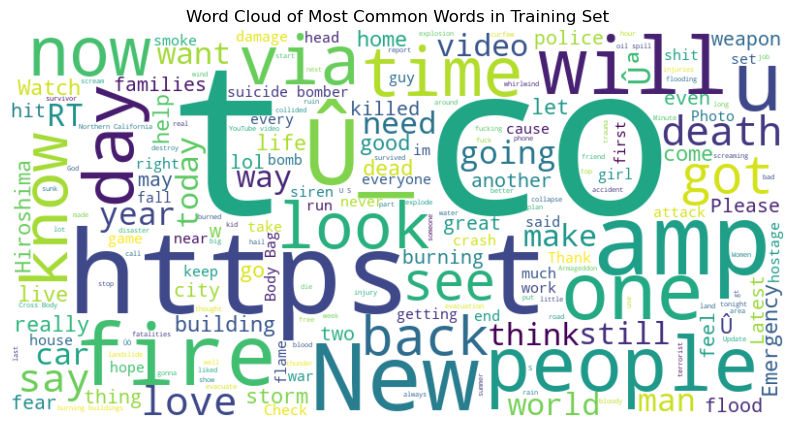

In [22]:
# Visualization of frequency of words

text_combined = ' '.join(train['text'])

plt.figure(figsize = (10, 6))
wordcloud = WordCloud(width = 800, 
                      height = 400, 
                      random_state = 42, 
                      background_color = 'white',
                     ).generate(text_combined)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words in Training Set')
plt.show()

In [23]:
# Stop Words

nltk.download('stopwords')
words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LEGION\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [26]:
stemmer = PorterStemmer()

In [27]:
# Data Cleaning using regex, stemmer and removing stopwords

train['cleaned'] = list(map(lambda x: " ".join([i for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]),train['text']))
train['cleaned'] = train['cleaned'].apply(lambda x: " ".join([stemmer.stem(i) for i in x.lower().split()]))

In [42]:
label_encoder = preprocessing.LabelEncoder()
train_target = label_encoder.fit_transform(train['target'])
X_train, X_val, y_train, y_val = train_test_split(train_text_features, 
                                                  train_target,
                                                  test_size = 0.2, 
                                                  random_state = 42)

In [43]:
# Model

model = LogisticRegression()

In [44]:
# Train the model

model.fit(X_train, y_train)

LogisticRegression()

In [45]:
# Creating a pickle file

with open('LogisticRegression1.pickle', 'wb') as f:
     pickle.dump(model, f)

In [49]:
# Train and Validation prediction

val_predictions = model.predict(X_val)
train_predictions = model.predict(X_train)


print("Train Accuracy:", accuracy_score(y_train, train_predictions))
print("Validation Accuracy:", accuracy_score(y_val, val_predictions))


Train Accuracy: 0.8888341543513957
Validation Accuracy: 0.8010505581089954


In [54]:
# Confusion Matrix and Classification Report

yval = np.array(y_val)

print(classification_report(yval, model.predict(X_val)))

print(confusion_matrix(yval, model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       874
           1       0.83      0.67      0.74       649

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.81      0.80      0.80      1523

[[788  86]
 [217 432]]


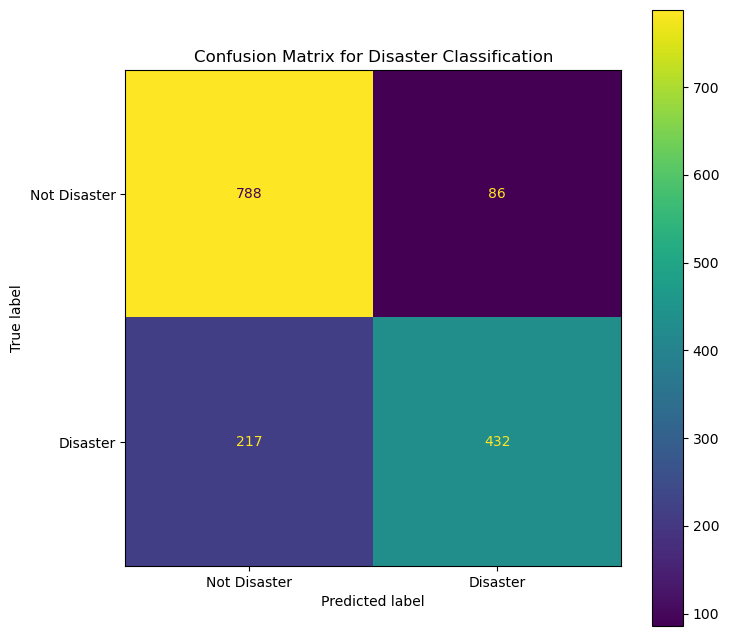

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(yval, model.predict(X_val))

fig, ax = plt.subplots(figsize=(8,8), dpi=100)

class_names = ['Not Disaster', 'Disaster']

display = ConfusionMatrixDisplay(cm, display_labels = class_names)

# set the plot title using the axes object
ax.set(title = 'Confusion Matrix for Disaster Classification')

display.plot(ax = ax);

In [56]:
# Running on cleaned data

X = train['cleaned']
y = train['target']
          
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

# Creating pipeline

pipeline = Pipeline([('vect', tfidf_vectorizer),
                     ('chi', SelectKBest(chi2, k = 2000)),
                     ('clf', LogisticRegression(random_state = 1))])

In [57]:
# Training the model
model = pipeline.fit(X_train, y_train)

In [58]:
# Creating a pickle file

with open('LogisticRegression2.pickle', 'wb') as f:
     pickle.dump(model, f)

In [59]:
# Accuracy

predict_test = model.predict(X_test)
predict_train = model.predict(X_train)
print("Test accuracy = ", accuracy_score(y_test, predict_test))
print("Train accuracy = ", accuracy_score(y_train, predict_train))

Test accuracy =  0.7994746059544658
Train accuracy =  0.8408283109256683


In [60]:
# Confusion Matrix and Classification Report

ytest = np.array(y_test)

print(classification_report(ytest, model.predict(X_test)))

print(confusion_matrix(ytest, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       644
           1       0.83      0.68      0.75       498

    accuracy                           0.80      1142
   macro avg       0.81      0.79      0.79      1142
weighted avg       0.80      0.80      0.80      1142

[[574  70]
 [159 339]]


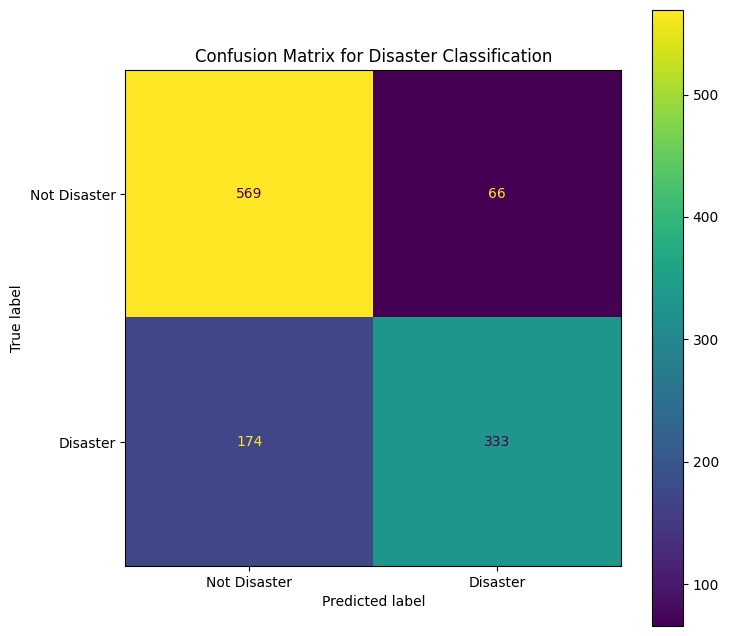

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(ytest, model.predict(X_test))

fig, ax = plt.subplots(figsize=(8,8), dpi=100)

class_names = ['Not Disaster', 'Disaster']

display = ConfusionMatrixDisplay(cm, display_labels = class_names)

# set the plot title using the axes object
ax.set(title = 'Confusion Matrix for Disaster Classification')

display.plot(ax = ax);